In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output

In [13]:
start = timer()
prep_dataset1 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized1.csv', delimiter=",")
prep_dataset2 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized2.csv', delimiter=",")
prep_dataset3 = pd.read_csv('datasets/com_concept_drift/sdn_train_unormalized3.csv', delimiter=",")
prep_test = pd.read_csv('datasets/com_concept_drift/sdn_test_unormalized.csv', delimiter=",")

prep_dataset1 = prep_dataset1[prep_dataset1.delay>0]
prep_dataset2 = prep_dataset2[prep_dataset2.delay>0]
prep_dataset3 = prep_dataset3[prep_dataset3.delay>0]
prep_test = prep_test[prep_test.delay>0]


,temperature,label,delay
0,19.3024,1,126.251634
1,19.1652,1,126.251634
2,19175.0000,1,126.251634
3,19.1456,1,126.251634
4,19.1652,1,126.251634
...,...,...,...
4895,19.5768,0,420.416429
4896,19.5866,0,420.416429
4897,19567.0000,0,420.416429
4898,19.5572,0,420.416429


# Normalizing

In [14]:
def normalizing(df):
    f_columns = ['timestamp','temperature']
    scaler1 = StandardScaler().fit(df)
    scaler2 = StandardScaler().fit(df)

    scaler1= scaler1.fit(df[f_columns].to_numpy())
    scaler2 = scaler2.fit(df[['delay']])

    df.loc[:,f_columns] = scaler1.transform(df[f_columns].to_numpy())
    df['delay'] = scaler2.transform(df[['delay']])
    return df


def unormalizing(df,Y_test,y_pred ):
    
    scaler = StandardScaler().fit(df)
    scaler = scaler.fit(df[['delay']])
    y_test_inv = scaler.inverse_transform(Y_test.reshape(1,-1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    return y_test_inv, y_pred_inv


In [15]:
def saveFile(dataset, name='dataset'):
    print('saving: ',name, '......')
    f = open(name,'w')
    try:
        writer = csv.writer(f)
        writer.writerow(dataset.columns)
        for i in np.arange(int(dataset.shape[0])):
            writer.writerow(dataset.iloc[i,])
    finally:
        f.close()
        

def preprocessing(dataset, order): 
    window = 50
    cont = 0;
    cols = ['timestamp','temperature','label' ,'delay' ]
    newSet = []
    while(cont<dataset.shape[0]):
        MyLIst = dataset.iloc[cont:cont+window,:]
        cont+=20
        deltaT = np.max(MyLIst.temperature) - np.min(MyLIst.temperature)
        deltaTime = np.max(MyLIst.seconds) - np.min(MyLIst.seconds)
        meanDelay = np.mean(MyLIst.delay)
        label=MyLIst.iloc[0,3]   
        newSet.append([deltaTime,deltaT,label,meanDelay])
    delta_df = pd.DataFrame(np.array(newSet), columns = cols)
    saveFile(delta_df, 'datasets/delta/sdn_train_mininet_unormalized_'+order+'.csv')
    norm = normalizing(delta_df)
    saveFile(norm, 'datasets/delta/sdn_train_mininet_normalized_'+order+'.csv')

    return norm
    

In [16]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []    
    for i in range(len(X) - time_steps):
        clear_output(wait=True)
        print('modeling to keras ',round((i/(len(X) - time_steps))*100,2), ('%'), end='')
        s = round(timer() - start)
        if(s>60):
            s /=60
            print(' ', s, ' seconds')
        v = X.iloc[i: (i+time_steps), 1:3].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
preprocessing(prep_dataset1, '1')
preprocessing(prep_dataset2, '2')
preprocessing(prep_dataset3, '3')
preprocessing(prep_test, 'test')

AttributeError: 'DataFrame' object has no attribute 'seconds'

In [8]:
prep_test[prep_test.label==1]

,timestamp,seconds,temperature,label,delay
15000,2004-03-09 21:31:13,1.078879e+09,22.2620,1,25621.0
15001,2004-03-09 21:31:43,1.078879e+09,22.2718,1,25621.0
15002,2004-03-09 21:32:07,1.078879e+09,22.2620,1,25621.0
15003,2004-03-09 21:33:04,1.078879e+09,22.2620,1,25621.0
15004,2004-03-09 21:33:42,1.078879e+09,22.2620,1,25621.0
...,...,...,...,...,...
24395,2004-03-18 05:41:30,1.079599e+09,20.8704,1,1051.0
24396,2004-03-18 05:41:58,1.079599e+09,20.8704,1,1051.0
24397,2004-03-18 05:42:55,1.079599e+09,20.8802,1,1051.0
24398,2004-03-18 05:43:45,1.079599e+09,20.8704,1,1051.0


In [9]:
def LSTMconf(X_train):
    print('Init config LSTM')
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                 activation="relu",
                units=512,
                input_shape=(X_train.shape[1],X_train.shape[2])
            )
        ))
    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    
    loss ="mse"
    optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001)
    metrics=["accuracy"]

    model.compile(loss=loss, optimizer=optim, 
#              metrics=metrics
             )
    return model
    

In [10]:
def LSTMfit(model,X_train,Y_train):
    print('Init Train')
    start = timer()
    history = model.fit(
        X_train, Y_train, 
        epochs=256, 
        batch_size= 128,
        validation_split=0.1,
        shuffle=False,
    #     callbacks=[tensorboard_callback]
    )
    return history


In [11]:
model = None
for i in range(1,4):
    
    train = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_'+str(i)+'.csv', delimiter=",")     
    X_train,Y_train = create_dataset(train, train.delay)
    if(model is None):
        model = LSTMconf(X_train)
    print('dataset: ',i)
    history = LSTMfit(model,X_train, Y_train)

# r = Timer(1.0, preprocessing, (prep_dataset.iloc[cont:cont+window,:]))
# r.start()
# print(X_train)
    

modeling to keras  99.93 %  4.8  seconds
Init Train
Epoch 1/256
11/11 [==============================] - 1s 47ms/step - loss: 0.5854 - val_loss: 5.2582
Epoch 2/256
11/11 [==============================] - 0s 46ms/step - loss: 0.5586 - val_loss: 5.2409
Epoch 3/256
11/11 [==============================] - 0s 44ms/step - loss: 0.5433 - val_loss: 5.2288
Epoch 4/256
11/11 [==============================] - 1s 46ms/step - loss: 0.5347 - val_loss: 5.2171
Epoch 5/256
11/11 [==============================] - 0s 45ms/step - loss: 0.5301 - val_loss: 5.2101
Epoch 6/256
11/11 [==============================] - 0s 45ms/step - loss: 0.5269 - val_loss: 5.2038
Epoch 7/256
11/11 [==============================] - 0s 45ms/step - loss: 0.5257 - val_loss: 5.2009
Epoch 8/256
11/11 [==============================] - 0s 45ms/step - loss: 0.5234 - val_loss: 5.1980
Epoch 9/256
11/11 [==============================] - 0s 46ms/step - loss: 0.5228 - val_loss: 5.1949
Epoch 10/256
11/11 [============================

11/11 [==============================] - 0s 39ms/step - loss: 0.5167 - val_loss: 5.1566
Epoch 162/256
11/11 [==============================] - 0s 38ms/step - loss: 0.5133 - val_loss: 5.1548
Epoch 163/256
11/11 [==============================] - 0s 39ms/step - loss: 0.5157 - val_loss: 5.1568
Epoch 164/256
11/11 [==============================] - 0s 38ms/step - loss: 0.5149 - val_loss: 5.1545
Epoch 165/256
11/11 [==============================] - 0s 38ms/step - loss: 0.5157 - val_loss: 5.1558
Epoch 166/256
11/11 [==============================] - 0s 37ms/step - loss: 0.5148 - val_loss: 5.1553
Epoch 167/256
11/11 [==============================] - 0s 38ms/step - loss: 0.5160 - val_loss: 5.1550
Epoch 168/256
11/11 [==============================] - 0s 37ms/step - loss: 0.5141 - val_loss: 5.1559
Epoch 169/256
11/11 [==============================] - 0s 38ms/step - loss: 0.5146 - val_loss: 5.1565
Epoch 170/256
11/11 [==============================] - 0s 39ms/step - loss: 0.5141 - val_loss: 5

In [12]:
print('Saving Model')
model.save('models/lstm')

Saving Model
INFO:tensorflow:Assets written to: models/lstm\assets


# loss training

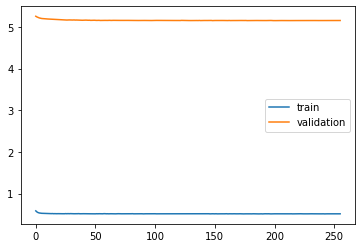

In [13]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend();

In [33]:
test_un = pd.read_csv('datasets/delta/sdn_train_mininet_unormalized_test.csv', delimiter=",")  
test = pd.read_csv('datasets/delta/sdn_train_mininet_normalized_test.csv', delimiter=",")     
X_test,Y_test = create_dataset(test, test.delay)

modeling to keras  99.92 %  25.216666666666665  seconds


# predicting

In [34]:
y_pred = model.predict(X_test)

# unormalizing

In [61]:
y_test_inv, y_pred_inv = unormalizing(test_un, Y_test, y_pred)


In [62]:
y_pred_inv

array([[138.05853],
       [220.15569],
       [176.91368],
       ...,
       [ 72.67007],
       [ 72.67007],
       [ 98.8259 ]], dtype=float32)

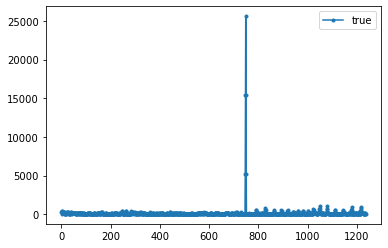

In [63]:
fig2 = plt.figure()
a2 = fig2.add_subplot(1,1,1)
a2.plot(y_test_inv.flatten(), marker='.', label='true')
a2.legend();

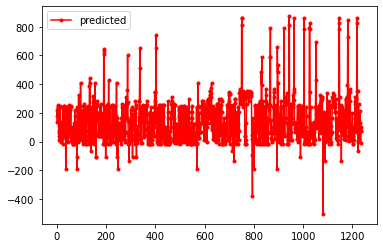

In [64]:
fig3 = plt.figure()
a3 = fig3.add_subplot(1,1,1)
a3.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a3.legend();

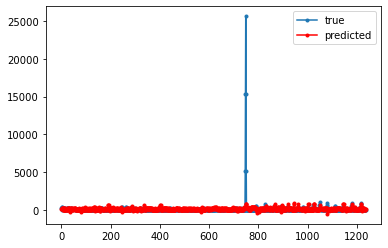

In [65]:
fig4 = plt.figure()
a4 = fig4.add_subplot(1,1,1)

a4.plot(y_test_inv.flatten(), marker='.', label='true')
a4.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a4.legend();

In [66]:
l1 = []
l2 = []
for i in np.arange(y_pred_inv.shape[0]):
    clear_output(wait=True)
    print('progress ',round((i/y_pred_inv.shape[0])*100,2), ('%'))
    if(y_pred_inv[i,0]<=1000):
        l1.append(y_pred_inv[i,0])
    if(y_test_inv[0,i]<=1000):
        l2.append(y_test_inv[0,i])

y_pred_inv2 = np.array(l1)
y_test_inv2 = np.array(l2)

progress  99.92 %


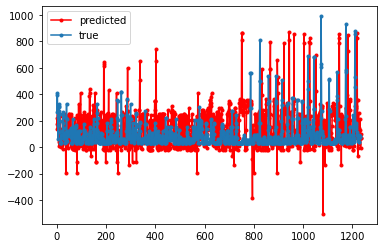

In [67]:
plt.plot(y_pred_inv2.flatten(),'r',marker='.', label='predicted')
plt.plot(y_test_inv2.flatten(), marker='.', label='true')
plt.legend();

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [69]:
size = np.min([y_pred_inv2.shape[0],y_test_inv2.shape[0] ])
rmse =  mean_squared_error(y_test_inv2[0:size], y_pred_inv2[0:size], squared=False)
mae =  mean_absolute_error(y_test_inv2[0:size], y_pred_inv2[0:size])
median_mae = median_absolute_error(y_test_inv2[0:size], y_pred_inv2[0:size])


print(rmse)
print(mae)
print(median_mae)

196.5686162879379
139.2522473817436
98.04070129394532


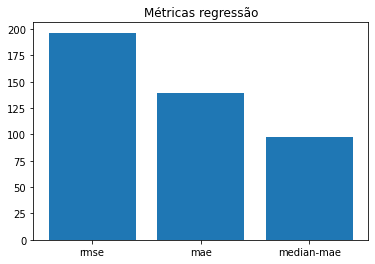

In [70]:
objects = ('rmse', 'mae', 'median-mae')
y_pos = np.arange(3)
performance = [rmse,mae,median_mae]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()

In [71]:
from sklearn.metrics import explained_variance_score

In [72]:
explained_variance_score(y_test_inv2[0:size], y_pred_inv2[0:size])

-2.2203144934599752

In [73]:
y_test_inv2[0:size]

array([264.        , 408.        , 396.        , ...,  91.        ,
        85.13513514,  78.23529412])